# 2-Phase Sensitivity Function

In [1]:
using DelayDiffEq
using PyPlot
using Statistics
using FileIO
using FFTW
include("GalerkinFuncs.jl");

In [2]:
# Model parameters
N  = 10
c1 = 0.1
c2 = 0.06
K  = 0.72
xf = 0.25
τ  = 0.2
Ma = 0.005
γ  = 1.4
# Create a structure of parameters
params = setParams(N,c1,c2,K,xf,τ,true);

#####################################
## Rijke tube Galerkin modes model ##
#####################################

##  Parameters ##
N  = 10
c1 = 0.1
c2 = 0.06
K  = 0.72
xf = 0.25
τ  = 0.2
#################



## Direct run

In [3]:
# Solve the direct equation
u0 = load("data/init.jld", "u0");
h(p,t) = u0
params.tMax  = 400
tspan = (-400,params.tMax+3)
lags = [τ]
prob = DDEProblem(RHS,u0,h,tspan,params,constant_lags=lags,reltol=1e-12)
alg = MethodOfSteps(Vern6())
@time solDir = solve(prob,alg);

 12.690460 seconds (145.10 M allocations: 7.342 GiB, 9.92% gc time)


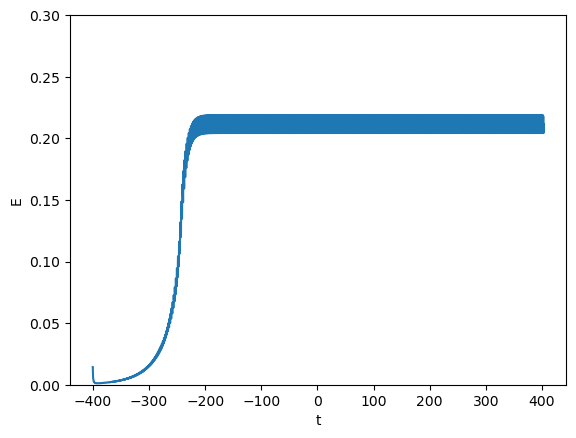

(0.0, 0.3)

In [4]:
# Check we've reached the limit cycle solution by t=0
EVec = zeros(length(solDir.t),1)
for i=1:length(solDir.t)
    EVec[i]=energy(solDir.u[i],params)
end
plot(solDir.t,EVec)
xlabel("t")
ylabel("E")
ylim([0,0.3])

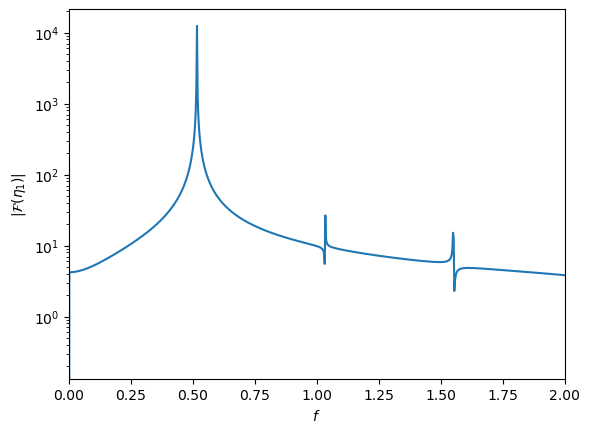

f_n = 0.5175
ω_n = 3.2515483964654357
T = 1.9323671497584543


1.9323671497584543

In [5]:
# Find the period using the FFT of first Galerkin mode
tRange = range(0,stop=400,length=400*100)
testSeries = zeros(length(tRange))
for (i,t) in enumerate(tRange)
    testSeries[i]=solDir(t)[1]
end
testSeriesFFT = fft(testSeries)
# Remove the mean
testSeriesFFT[1] = 0
dt = tRange[2]-tRange[1]
Sfreq = 1/dt
freqs = range(0,Sfreq,length=400*100)
idx = argmax(abs.(testSeriesFFT[1:200*100]))
semilogy(freqs,abs.(testSeriesFFT))
xlim([0,2])
xlabel(L"f")
ylabel(L"\|\mathcal{F}(\eta_1)\|")
T = 1/freqs[idx]
ωn = 2π/T
println("f_n = ",freqs[idx])
println("ω_n = ",2π*freqs[idx])
println("T = ",T)
params.T = T

In [6]:
# View the limit cycle
tRange = range(-400,stop=params.T,length=400*100)
xRange = [0.2]
U = zeros(length(xRange),length(tRange))
P = zeros(length(xRange),length(tRange))
for (index,t) in enumerate(tRange)
    y = params.solDir(t)
    u,p = pressureVelocity(y,xRange,params)
    U[1:end,index] = u
    P[1:end,index] = p
end

plot(P[1,:],U[1,:])
xlabel("p")
ylabel("u")

LoadError: MethodError: objects of type Bool are not callable

# Adjoint run

In [7]:
# Add the direct solution to the parameters for the adjoint equation
params.solDir = solDir;

In [8]:
# Run the adjoint from tMax back to zero
tspan = (0,params.tMax)
# The following prefactor automatically gives the phase sensitivity function 
# the correct normalisation for this case
prefactor = -3.2515483964654357/0.07683179773694698
u0 = prefactor*load("data/initAdj.jld","u0")
h(p,t) = u0
prob = DDEProblem(RHSadj,u0,h,tspan,params,constant_lags=lags,reltol=1e-12)
alg = MethodOfSteps(Vern6())
@time solAdj = solve(prob,alg)
params.solAdj = solAdj;

 40.318986 seconds (1.22 G allocations: 36.553 GiB, 9.50% gc time)


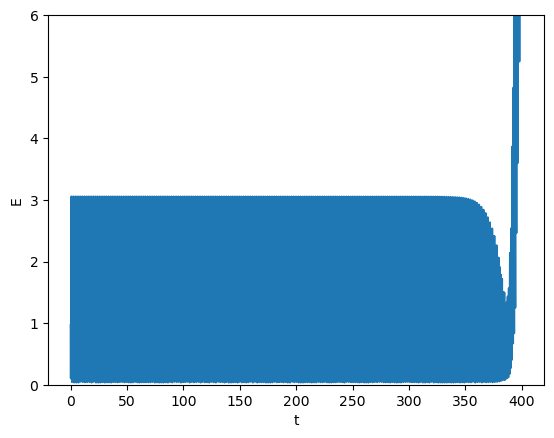

PyObject Text(24.000000000000007, 0.5, 'E')

In [9]:
# Check we've reached the limit cycle solution by t=0
EVec = zeros(length(solAdj.t),1)
for i=1:length(solAdj.t)
    EVec[i]=energy(solAdj.u[i],params)
end
plot(adjTime(solAdj.t),EVec)
ylim([0,6])
xlabel("t")
ylabel("E")

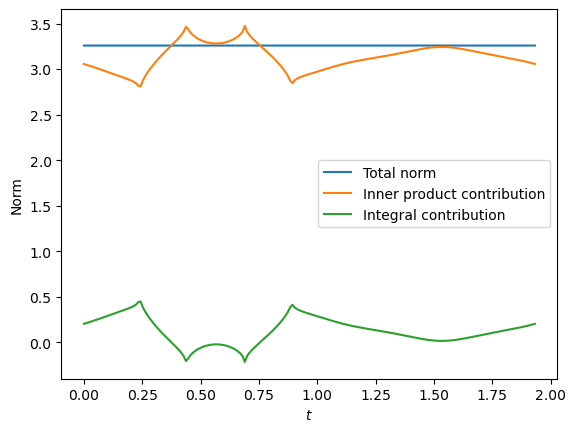

Norm = 0.9979874809000634


PyObject Text(0.5, 24.0, '$t$')

In [10]:
# Calculate the Bilinear form and plot the result
NT = 200
tRange = range(0,stop=params.T,length=NT)
norm = zeros(NT)
int = zeros(NT)
inner = zeros(NT)
for (i,t) in enumerate(tRange)
    norm[i],inner[i],int[i] = bilinearForm(2*params.T+t,params)
end
normV = mean(norm)
params.phaseSensNorm = ωn/normV
println("Norm = ",params.phaseSensNorm)
plot(tRange,norm)
plot(tRange,inner)
plot(tRange,int)
legend(["Total norm","Inner product contribution","Integral contribution"])

ylabel("Norm")
xlabel(L"t")

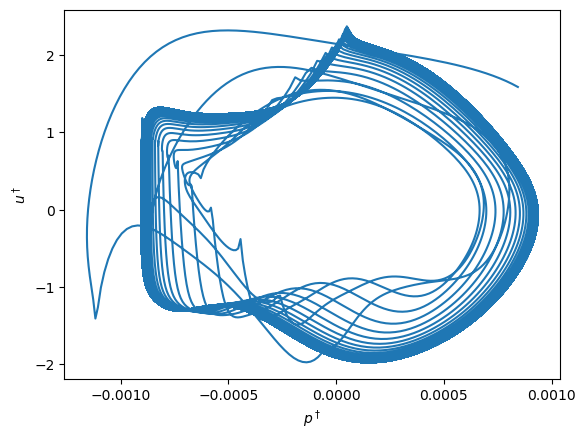

PyObject Text(28.600000000000016, 0.5, '$u^\\dagger$')

In [11]:
# View the adjoint limit cycle
tRange = range(0,stop=400,length=400*100)
xRange = [0.2]
UAdj = zeros(length(xRange),length(tRange))
PAdj = zeros(length(xRange),length(tRange))
for (index,t) in enumerate(tRange)
    y = params.solAdj(adjTime(t))*params.phaseSensNorm
    uAdj,pAdj = pressureVelocity(y,xRange,params)
    UAdj[1:end,index] = uAdj
    PAdj[1:end,index] = pAdj
end
plot(PAdj[1,1:400*100-800],UAdj[1,1:400*100-800])
xlabel(L"p^\dagger")
ylabel(L"u^\dagger")

In [12]:
# Save the phase sensitivity function for use in 3-PhaseCouplingFunction
save("phaseSensitivity.jld2", "params",params)